# Chapter 14
Analytic methods

## Reading

In [1]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkstats2.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkplot.py")

In [2]:
import numpy as np
import pandas as pd

import random

import thinkstats2
import thinkplot

In [3]:
import scipy.stats


def EvalNormalCdfInverse(p, mu=0, sigma=1):
    return scipy.stats.norm.ppf(p, loc=mu, scale=sigma)

In [4]:
EvalNormalCdfInverse(0.05, mu=90, sigma=2.5), EvalNormalCdfInverse(0.95, mu=90, sigma=2.5)

(85.88786593262132, 94.11213406737868)

In [5]:
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/normal.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/hypothesis.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/nsfg2.py")

download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/nsfg.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/first.py")

Downloaded normal.py
Downloaded hypothesis.py
Downloaded nsfg2.py


In [6]:
from normal import Normal

dist = Normal(90, 7.5**2)
dist

Normal(90, 56.25)

In [7]:
# Sampling distribution of the mean
dist_xbar = dist.Sum(9) / 9 # 9 measurements
dist_xbar.sigma

2.5

In [8]:
dist_xbar.Percentile(5), dist_xbar.Percentile(95)

(85.88786593262132, 94.11213406737868)

### Central Limit Theorem
If you add up independent variates from a distribution with finite mean and variance, the sum converges on a normal distribution.

In [9]:
def MakeExpoSamples(beta=2.0, iters=1000):
    samples = []
    for n in [1, 10, 100]:
        sample = [np.sum(np.random.exponential(beta, n)) for _ in range(iters)]
        samples.append((n, sample))
        
    return samples

In [10]:
def NormalPlotSamples(samples, plot=1, ylabel=""):
    """Makes normal probability plots for samples.

    samples: list of samples
    label: string
    """
    for n, sample in samples:
        thinkplot.SubPlot(plot)
        thinkstats2.NormalProbabilityPlot(sample)

        thinkplot.Config(
            title="n=%d" % n,
            legend=False,
            xticks=[],
            yticks=[],
            xlabel="random normal variate",
            ylabel=ylabel,
        )
        plot += 1

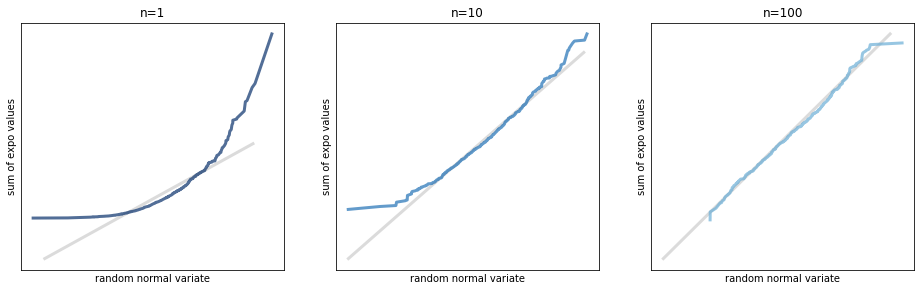

In [11]:
thinkplot.PrePlot(num=3, rows=2, cols=3)
samples = MakeExpoSamples()
NormalPlotSamples(samples, plot=1, ylabel="sum of expo values")

In [12]:
def MakeLognormalSamples(mu=1.0, sigma=1.0, iters=1000):
    """Generates samples from a lognormal distribution.

    mu: parmeter
    sigma: parameter
    iters: number of samples to generate for each size

    returns: list of samples
    """
    samples = []
    for n in [1, 10, 100]:
        sample = [np.sum(np.random.lognormal(mu, sigma, n)) for _ in range(iters)]
        samples.append((n, sample))
    return samples

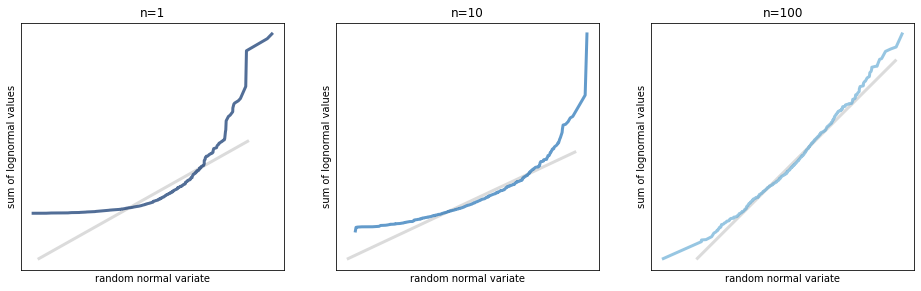

In [13]:
thinkplot.PrePlot(num=3, rows=2, cols=3)
samples = MakeLognormalSamples()
NormalPlotSamples(samples, ylabel="sum of lognormal values")

In [14]:
def MakeParetoSamples(alpha=1.0, iters=1000):
    """Generates samples from a Pareto distribution.

    alpha: parameter
    iters: number of samples to generate for each size

    returns: list of samples
    """
    samples = []

    for n in [1, 10, 100]:
        sample = [np.sum(np.random.pareto(alpha, n)) for _ in range(iters)]
        samples.append((n, sample))
    return samples

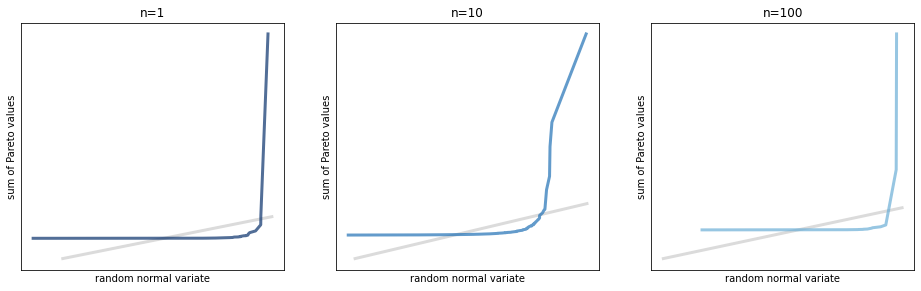

In [15]:
thinkplot.PrePlot(num=3, rows=2, cols=3)
samples = MakeParetoSamples()
NormalPlotSamples(samples, ylabel="sum of Pareto values")

This doesn't work because this distribution doesn't have finite mean and variance.

### Compute a CI and p-value for an observed difference in means.

The distribution of pregnancy length is not normal, but it has finite mean and variance, so the sum (or mean) of a few thousand samples is very close to normal.

In [16]:
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dct")
download(
    "https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dat.gz"
)

In [17]:
import first

live, firsts, others = first.MakeFrames()
delta = firsts.prglngth.mean() - others.prglngth.mean()
delta

0.07803726677754952

In [34]:
def SamplingDistMean(data, n):
    """
    Computes the sampling distribution of the mean.
    """
    mean, var = data.mean(), data.var()
    dist = Normal(mean, var)
    return dist.Sum(n) / n

In [35]:
dist1 = SamplingDistMean(live.prglngth, len(firsts))
dist2 = SamplingDistMean(live.prglngth, len(others))

In [36]:
dist_diff = dist1 - dist2
dist_diff

Normal(0, 0.00319708)

Under the null hypothesis, here's the chance of exceeding the observed difference:

In [37]:
1 - dist_diff.Prob(delta)

0.08377070425543831

This is the one-sided p-value.

Probability of falling below the negated difference:

In [38]:
dist_diff.Prob(-delta)

0.08377070425543826

Two-sided p-value:

In [39]:
1 - dist_diff.Prob(delta) + dist_diff.Prob(-delta)

0.16754140851087657

### Testing a correlation

Under the null hypothesis (that there is no correlation), the sampling distribution of the observed correlation (suitably transformed) is a "Student t" distribution.

In [40]:
def StudentCdf(n):
    """
    Computes the CDF of correlations from uncorrelated variables.
    n: sample size.
    """
    ts = np.linspace(-3, 3, 101)
    ps = scipy.stats.t.cdf(ts, df=n-2)
    rs = ts / np.sqrt(n - 2 + ts**2)
    
    return thinkstats2.Cdf(rs, ps)

Compare estimation by permutation and the Student t distribution:

In [41]:
import hypothesis


class CorrelationPermute(hypothesis.CorrelationPermute):
    """Tests correlations by permutation."""

    def TestStatistic(self, data):
        """Computes the test statistic.

        data: tuple of xs and ys
        """
        xs, ys = data
        return np.corrcoef(xs, ys)[0][1]

In [42]:
def ResampleCorrelations(live):
    """Tests the correlation between birth weight and mother's age.

    live: DataFrame for live births

    returns: sample size, observed correlation, CDF of resampled correlations
    """
    live2 = live.dropna(subset=["agepreg", "totalwgt_lb"])
    data = live2.agepreg.values, live2.totalwgt_lb.values
    ht = CorrelationPermute(data)
    p_value = ht.PValue()
    return len(live2), ht.actual, ht.test_cdf

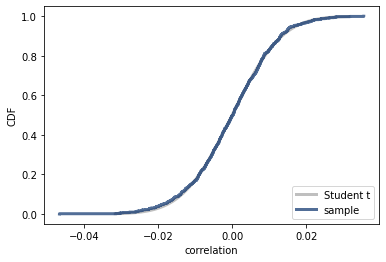

In [43]:
n, r, cdf = ResampleCorrelations(live)

model = StudentCdf(n)
thinkplot.Plot(model.xs, model.ps, color="gray", alpha=0.5, label="Student t")
thinkplot.Cdf(cdf, label="sample")

thinkplot.Config(xlabel="correlation", ylabel="CDF", legend=True, loc="lower right")

Use the CDF of the Student t distribution to compute a p-value:

In [44]:
t = r * np.sqrt((n - 2) / (1 - r**2))
p_value = 1 - scipy.stats.t.cdf(t, df=n - 2)
print(r, p_value)

0.06883397035410904 2.861466619208386e-11


### Chi-squared test

In [45]:
def ChiSquaredCdf(n):
    """Discrete approximation of the chi-squared CDF with df=n-1.

    n: sample size

    returns: Cdf
    """
    xs = np.linspace(0, 25, 101)
    ps = scipy.stats.chi2.cdf(xs, df=n - 1)
    return thinkstats2.Cdf(xs, ps)

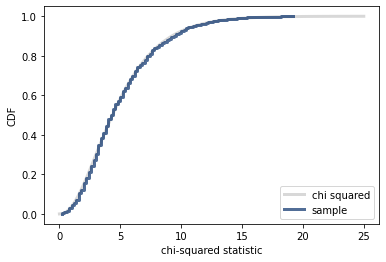

In [46]:
data = [8, 9, 19, 5, 8, 11]
dt = hypothesis.DiceChiTest(data)
p_value = dt.PValue(iters=1000)
n, chi2, cdf = len(data), dt.actual, dt.test_cdf

model = ChiSquaredCdf(n)
thinkplot.Plot(model.xs, model.ps, color="gray", alpha=0.3, label="chi squared")
thinkplot.Cdf(cdf, label="sample")

thinkplot.Config(xlabel="chi-squared statistic", ylabel="CDF", loc="lower right")

In [47]:
p_value = 1 - scipy.stats.chi2.cdf(chi2, df=n - 1)
print(chi2, p_value)

11.6 0.04069938850404997


## Exercises

**Exercise:**    In Section 5.4, we saw that the distribution of adult weights is approximately lognormal. One possible explanation is that the weight a person gains each year is proportional to their current weight. In that case, adult weight is the product of a large number of multiplicative factors:

$w = w_0 f_1 f_2 \dots f_n$

where $w$ is adult weight, $w_0$ is birth weight, and $f_i$ is the weight gain factor for year $i$.

The log of a product is the sum of the logs of the factors:

$\log w = \log w_0 + \log f_1 + \log f_2 + \dots + \log f_n$

So by the Central Limit Theorem, the distribution of $\log w$ is approximately normal for large $n$, which implies that the distribution of $w$ is lognormal.

To model this phenomenon, choose a distribution for $f$ that seems reasonable, then generate a sample of adult weights by choosing a random value from the distribution of birth weights, choosing a sequence of factors from the distribution of $f$, and computing the product. What value of $n$ is needed to converge to a lognormal distribution?

---
Let's say $f$ is uniformly distributed between 1 and 1.3 - this means that a person will gain 0 to 30% of their bodyweight each year.

Let's generate 1000 adult weights from 1000 birth weights for $n = 1, 10, 50, 100$.

In [52]:
birth_weights = random.sample(list(live.totalwgt_lb.dropna()), 1000)

In [57]:
def calculate_adult_weights(birth_weights, n):
    """
    Calculate adult weights for n years.
    """
    adult_weights = []
    for birth_weight in birth_weights:
        fs = np.random.uniform(1, 1.3, n)
        adult_weight = birth_weight * np.product(fs)
        adult_weights.append(adult_weight)
        
    return adult_weights

In [58]:
adult_weights_ns = [(n, calculate_adult_weights(birth_weights, n)) for n in (1, 10, 50, 100)]

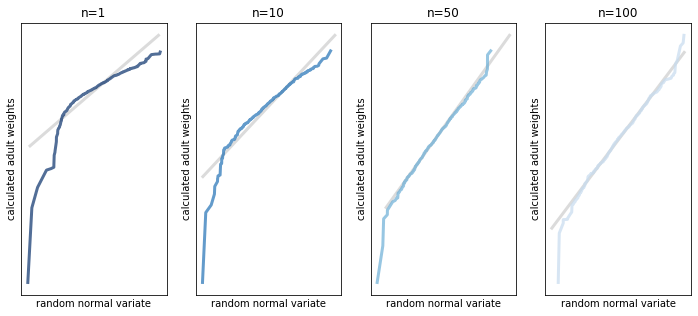

In [59]:
samples = [(n, np.log(np.array(adult_weights_n))) for n, adult_weights_n in adult_weights_ns]

thinkplot.PrePlot(num=4, cols=4)
NormalPlotSamples(samples, plot=1, ylabel='calculated adult weights')

This actually already works kind of well for n = 10 and improves for n = 50 and n = 100.

**Exercise:** In Section 14.6 we used the Central Limit Theorem to find the sampling distribution of the difference in means, δ, under the null hypothesis that both samples are drawn from the same population.

We can also use this distribution to find the standard error of the estimate and confidence intervals, but that would only be approximately correct. To be more precise, we should compute the sampling distribution of δ under the alternate hypothesis that the samples are drawn from different populations.

Compute this distribution and use it to calculate the standard error and a 90% confidence interval for the difference in means.

In [60]:
dist1 = SamplingDistMean(firsts.prglngth, len(firsts))
dist2 = SamplingDistMean(others.prglngth, len(others))

dist = dist1 - dist2
dist

Normal(0.0780373, 0.00321144)

The standard error is the standard deviation of the sampling distribution:

In [61]:
dist.sigma

0.05666953041905667

The 90% CI is the interval between the 5th percentile and the 95% percentile:

In [62]:
dist.Percentile(5), dist.Percentile(95)

(-0.01517581586986555, 0.17125034942497877)

**Exercise:** [In a recent paper](http://ieeexplore.ieee.org/document/7044435/), Stein et al. investigate the effects of an intervention intended to mitigate gender-stereotypical task allocation within student engineering teams.

Before and after the intervention, students responded to a survey that asked them to rate their contribution to each aspect of class projects on a 7-point scale.

Before the intervention, male students reported higher scores for the programming aspect of the project than female students; on average men reported a score of 3.57 with standard error 0.28. Women reported 1.91, on average, with standard error 0.32.

Compute the sampling distribution of the gender gap (the difference in means), and test whether it is statistically significant. Because you are given standard errors for the estimated means, you don’t need to know the sample size to figure out the sampling distributions.

After the intervention, the gender gap was smaller: the average score for men was 3.44 (SE 0.16); the average score for women was 3.18 (SE 0.16). Again, compute the sampling distribution of the gender gap and test it.

Finally, estimate the change in gender gap; what is the sampling distribution of this change, and is it statistically significant?

In [63]:
mean_m_before = 3.57
stderr_m_before = 0.28

mean_f_before = 1.91
stderr_f_before = 0.32

mean_m_after = 3.44
stderr_m_after = 0.16

mean_f_after = 3.18
stderr_f_after = 0.16

gap_before = mean_m_before - mean_f_before
gap_after = mean_m_after - mean_f_after

delta_gap = gap_before - gap_after

In [73]:
dist_m_before = Normal(mean_m_before, stderr_m_before**2)
dist_f_before = Normal(mean_f_before, stderr_f_before**2)

dist_diff_before = dist_m_before - dist_f_before

Mean:

In [74]:
dist_diff_before.mu

1.66

p-value: (probability of a difference of 0 or less)

In [75]:
dist_diff_before.Prob(0)

4.730953232082172e-05

This is a small p-value, so the difference is significant.

90% CI:

In [76]:
dist_diff_before.Percentile(5), dist_diff_before.Percentile(95)

(0.9605986441960159, 2.3594013558039837)

Standard error:

In [77]:
dist_diff_before.sigma

0.425205832509386

In [78]:
dist_m_after = Normal(mean_m_after, stderr_m_after**2)
dist_f_after = Normal(mean_f_after, stderr_f_after**2)

dist_diff_after = dist_m_after - dist_f_after

Mean:

In [79]:
dist_diff_after.mu

0.2599999999999998

p-value: (probability of a difference of 0 or less)

In [80]:
dist_diff_after.Prob(0)

0.12526798720681914

This is p > 0.05, so this difference is not statistically significant.

90% CI:

In [81]:
dist_diff_after.Percentile(5), dist_diff_after.Percentile(95)

(-0.11218788917653594, 0.6321878891765353)

Standard error:

In [82]:
dist_diff_after.sigma

0.2262741699796952

In [83]:
dist_diff_gap = dist_diff_before - dist_diff_after

Mean:

In [84]:
dist_diff_gap.mu

1.4000000000000001

p-value: (probability of a difference of 0 or less)

In [85]:
dist_diff_gap.Prob(0)

0.0018269483689769925

This is p < 0.05, so this difference is statistically significant.

90% CI:

In [86]:
dist_diff_gap.Percentile(5), dist_diff_gap.Percentile(95)

(0.6077335793117721, 2.192266420688228)

Standard error:

In [87]:
dist_diff_gap.sigma

0.48166378315169184